In [1]:
import os
import json
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf

from scipy.optimize import curve_fit

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

In [2]:
product, time_reso = 'CMORPH', '3h'

In [3]:
yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CMORPH_3h.json
Number of threads: 27
Neighborhood area: 5x5



In [5]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [6]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    VENETO_DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_1000.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [7]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 47MB
Dimensions:  (time: 32144, lat: 18, lon: 20)
Coordinates:
  * lat      (lat) float32 72B 43.62 43.88 44.12 44.38 ... 47.38 47.62 47.88
  * lon      (lon) float32 80B 9.625 9.875 10.12 10.38 ... 13.88 14.12 14.38
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 46MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [8]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 568B
Dimensions:  (lat: 10, lon: 12)
Coordinates:
  * lat      (lat) float32 40B 44.62 44.88 45.12 45.38 ... 46.38 46.62 46.88
  * lon      (lon) float32 48B 10.62 10.88 11.12 11.38 ... 12.88 13.12 13.38
Data variables:
    PRE      (lat, lon) float32 480B 1.853 1.702 1.577 ... 1.857 2.041 2.203

Text(0.0, 1.0, 'Study Region (Red) and Extended Area (Blue)')

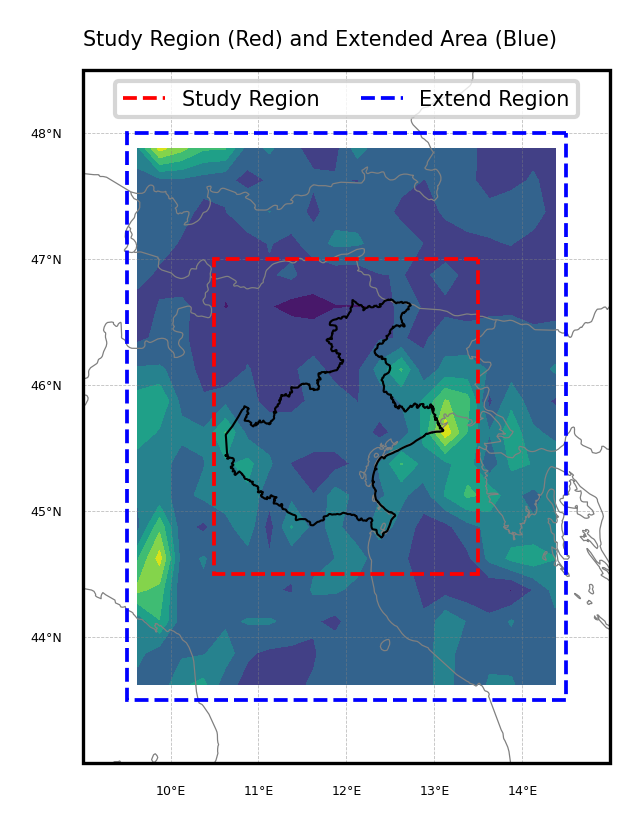

In [9]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-1.5, lon_max+1.5, lat_min-1.5, lat_max+1.5],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=5,ncols=2,loc='upper center')
ax1.set_title('Study Region (Red) and Extended Area (Blue)', loc='left', fontsize=5)

In [10]:
lon2d_SR, lat2d_SR = np.meshgrid(lons[ndices_lon], lats[ndices_lat])

In [13]:
nn = 0
for i in range(len(ndices_lat)):#len(ndices_lat)
    for j in range(len(ndices_lon)):#len(ndices_lon)
        lat_c = lats[ndices_lat[i]]
        lon_c = lons[ndices_lon[j]]
        PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 2)
        lat_box = BOX['lat'].data
        lon_box = BOX['lon'].data
        box_lon2d, box_lat2d = np.meshgrid(lon_box, lat_box)

        mask = np.full(lat2d.shape, False, dtype=bool)
        for la, lo in itertools.product(lat_box, lon_box):
            mask[(lat2d == la) & (lon2d == lo)] = True

        BOX2 = BOX.transpose("lon", "lat", "time")
        BOX2 = BOX2['PRE']

        tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*param['dt']

        smax = BOX2.shape[0]
        tscales = tscales[tscales < param['tmax'] + 0.001]
        xscales = np.arange(1, smax+1)
        xscales_km = xscales*param['L1']

        WET_MATRIX = ART_pre.space_time_scales_agregations(
                    BOX2, 
                    param['L1'], 
                    param['condition'], 
                    tscales, 
                    xscales, 
                    2*param['npix']+1, 
                    param['thresh'])

        nxscales = np.size(xscales)

        tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
        WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

        for col in range(nxscales):
            WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

        WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
                    WET_MATRIX_INTER, 
                    xscales_km, 
                    tscales_INTER, 
                    param['L1'], 
                    param['npix'])

        vdist, vcorr = ART_pre.autocorrelation_neighborhood_v2(
                            BOX, 
                            time_reso, 
                            param['target_t'], 
                            param['thresh'])

        FIT1, _ = curve_fit(ART_down.epl_fun, vdist, vcorr)
        xx = np.sort(vdist)

        cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
        norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

        cmap = plt.cm.Spectral_r
        proj = ccrs.PlateCarree()

        fig = plt.figure(figsize=(6,4),dpi=300)
        gs = gridspec.GridSpec(2,2)

        # ============================================================================================================================
        ax1 = plt.subplot(gs[0:, 0], projection = proj)
        ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
        ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
        ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
        VENETO_DEM.plot(facecolor='None', ax=ax1, zorder=10, color='grey', linewidth=0.2, alpha=0.3)
        VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
        ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
        ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
        gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xlabel_style = {'size': 4, 'color': 'k'}
        gl.ylabel_style = {'size': 4, 'color': 'k'}

        a1 = ax1.pcolormesh(lon2d, lat2d, mask, cmap=cmap_bin, norm=norm)

        ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
        ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

        ax1.scatter(box_lon2d, box_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
        ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

        ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
        ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

        ax1.set_title('(a) Neighborhood Area (5x5)', loc='left', fontsize=7)
        ax1.legend(ncol=3, fontsize=5, bbox_to_anchor=(1.1, -0.05))

        # ============================================================================================================================
        ax1 = plt.subplot(gs[0, 1])
        ax1.tick_params(axis='both', which='major', labelsize=4)

        ax1.contourf(new_spatial_scale,tscales_INTER,WET_MATRIX_EXTRA)
        ax1.axvline(0, c='k', linestyle='--', linewidth=0.5)
        ax1.axvline(25, c='k', linestyle='--', linewidth=0.5)

        ax1.set_xticks([0, 25,  50,  75, 100, 125])
        ax1.set_xticklabels([0, 25,  50,  75, 100, 125])
        ax1.set_yticks(tscales)
        ax1.set_yticklabels(tscales)
        ax1.grid(linewidth=0.2, linestyle='--', c='k', alpha=0.3)
        ax1.scatter(25, 24, s=2, color='r', marker='s', zorder=10, label='Original scale')
        ax1.scatter(0, 24, s=2, color='r', marker='^', zorder=10, label='Point scale')

        ax1.set_xlim(-5, 125)

        ax1.set_title('(b) Wet fraction two scales (Beta)', loc='left', fontsize=7)
        ax1.set_ylabel('Time Scale aggregation (hours)', fontsize=5, labelpad=2)
        ax1.set_xlabel('Spatial Scale aggregation (km)', fontsize=5, labelpad=2)
        ax1.legend(fontsize=4, loc=1)

        # ============================================================================================================================
        ax1 = plt.subplot(gs[1, 1])
        ax1.tick_params(axis='both', which='major', labelsize=4)

        ax1.plot(vdist, vcorr, '.', markersize=1, label='Correlation')
        ax1.plot(xx, ART_down.epl_fun(xx, FIT1[0], FIT1[1]), color='r', linewidth=0.5, label='Exp. Power Law')

        ax1.set_ylim(0.2, 1)
        # ax1.set_xlim(80, 700)
        ax1.grid(linewidth=0.2, linestyle='--', c='k', alpha=0.3)
        ax1.set_title('(c) Spatial Correlation (Gamma)', loc='left', fontsize=7)
        ax1.set_ylabel('Correlation', fontsize=5, labelpad=2)
        ax1.set_xlabel('Distance (km)', fontsize=5, labelpad=2)
        ax1.legend(fontsize=4, loc=1)

        # ================================================================================================
        ax1.set_facecolor('white')
        fig.patch.set_alpha(0)

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.35, wspace=0.2)

        salida = os.path.join('..','fig','gif',f'VENETO_{str(nn).zfill(3)}.png')
        print(f'Export figure to: {salida}')
        plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

        plt.close()

        nn += 1

Export figure to: ../fig/gif/VENETO_000.png
Export figure to: ../fig/gif/VENETO_001.png
Export figure to: ../fig/gif/VENETO_002.png
Export figure to: ../fig/gif/VENETO_003.png
Export figure to: ../fig/gif/VENETO_004.png
Export figure to: ../fig/gif/VENETO_005.png
Export figure to: ../fig/gif/VENETO_006.png
Export figure to: ../fig/gif/VENETO_007.png
Export figure to: ../fig/gif/VENETO_008.png
Export figure to: ../fig/gif/VENETO_009.png
Export figure to: ../fig/gif/VENETO_010.png
Export figure to: ../fig/gif/VENETO_011.png
Export figure to: ../fig/gif/VENETO_012.png
Export figure to: ../fig/gif/VENETO_013.png
Export figure to: ../fig/gif/VENETO_014.png
Export figure to: ../fig/gif/VENETO_015.png
Export figure to: ../fig/gif/VENETO_016.png
Export figure to: ../fig/gif/VENETO_017.png
Export figure to: ../fig/gif/VENETO_018.png
Export figure to: ../fig/gif/VENETO_019.png
Export figure to: ../fig/gif/VENETO_020.png
Export figure to: ../fig/gif/VENETO_021.png
Export figure to: ../fig/gif/VEN

In [ ]:
# fig = plt.figure(figsize=(4,4),dpi=300)
# gs = gridspec.GridSpec(1,1)

# # ============================================================================================================================
# ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
# ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
# ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
# VENETO_DEM.plot(facecolor='None', ax=ax1, zorder=10, color='grey', linewidth=0.2, alpha=0.3)
# VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.6, alpha=0.5)
# ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
# ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
# gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
# gl.top_labels = False
# gl.bottom_labels = True
# gl.right_labels = False
# gl.xlabel_style = {'size': 4, 'color': 'k'}
# gl.ylabel_style = {'size': 4, 'color': 'k'}

# a1 = ax1.pcolormesh(lon2d, lat2d, mask, cmap=cmap_bin, norm=norm)

# ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
# ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

# ax1.scatter(box_lon2d, box_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
# ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

# ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
# ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

# ax1.set_title('(a) Neighborhood Area (5x5)', loc='left', fontsize=7)
# ax1.legend(ncol=3, fontsize=5, bbox_to_anchor=(1.1, -0.05))